In [1]:
import os
import numpy as np
import quaternion
import matplotlib.pyplot as plt

import habitat
from habitat.config import read_write
from habitat.config.default import get_agent_config

import torch.nn.functional as F
import torch
from torchvision.transforms import ToTensor

# Set up the environment for testing
config = habitat.get_config("benchmark/nav/pointnav/pointnav_habitat_test.yaml")
with read_write(config):
    config.habitat.dataset.split = "train"
    agent_config = get_agent_config(sim_config=config.habitat.simulator)
    agent_config.sim_sensors.depth_sensor.normalize_depth = False

# Intrinsic parameters, assuming width matches height. Requires a simple refactor otherwise
W = agent_config.sim_sensors.depth_sensor.width
H = agent_config.sim_sensors.depth_sensor.height

assert(W == H)
hfov = float(agent_config.sim_sensors.depth_sensor.hfov) * np.pi / 180.


env = habitat.Env(config=config)


obs = env.reset()
initial_state = env._sim.get_agent_state(0)
init_translation = initial_state.position
init_rotation = initial_state.rotation

pybullet build time: May 20 2022 19:45:31
2023-11-09 21:29:31,514 Initializing dataset PointNav-v1
2023-11-09 21:29:31,740 initializing sim Sim-v0
[21:29:31:867307]:[Warning]:[Assets] ResourceManager.cpp(353)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SceneInstanceAttributes-provided name : `data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` nor constructed filename : `data/scene_datasets/habitat-test-scenes/info_semantic.json` exist on disk.
[21:29:32:658559]:[Warning]:[Sim] Simulator.cpp(508)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0
2023-11-09 21:29:32,660 Initializing task Nav-v0


Renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.104.12
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


In [2]:
agent_config.sim_sensors.depth_sensor

{'type': 'HabitatSimDepthSensor', 'height': 256, 'width': 256, 'position': [0.0, 1.25, 0.0], 'orientation': [0.0, 0.0, 0.0], 'hfov': 90, 'sensor_subtype': 'PINHOLE', 'noise_model': 'None', 'noise_model_kwargs': {}, 'min_depth': 0.0, 'max_depth': 10.0, 'normalize_depth': False}

In [3]:
init_translation = init_translation + np.array([1.5, 0, 0])

In [4]:
def uniform_quat(original_angle):
    original_euler = quaternion.as_euler_angles(original_angle)
    euler_angles = np.array([(np.random.rand() - 0.5) * np.pi / 9. + original_euler[0],
                            (np.random.rand() - 0.5) * np.pi / 9. + original_euler[1],
                            (np.random.rand() - 0.5) * np.pi / 9. + original_euler[2]])
    quaternions = quaternion.from_euler_angles(euler_angles)


    return quaternions

In [5]:
depths = []
rgbs = []
cameras = []


for i in range(0, 2):
    rotation = uniform_quat(init_rotation)
    translation = init_translation + np.random.rand(3,) * 0.5 - 0.25

    obs = env._sim.get_observations_at(position=translation, rotation=rotation, keep_agent_at_new_pose=True)
    depths += [obs["depth"][...,0]]
    rgbs += [obs["rgb"]]

    cameras += [env._sim.get_agent_state()]

env.close()

In [6]:
depths[0].max()

3.419908

In [7]:
cameras[0]

AgentState(position=array([-5.6975613 , -0.16487882,  6.387084  ], dtype=float32), rotation=quaternion(0.663695275783539, -0.0155195770785213, 0.747832834720612, -0.00371578615158796), sensor_states={'rgb': SixDOFPose(position=array([-5.720411 ,  1.0844845,  6.3543863], dtype=float32), rotation=quaternion(0.663695275783539, -0.0155195770785213, 0.747832834720612, -0.00371578615158796)), 'depth': SixDOFPose(position=array([-5.720411 ,  1.0844845,  6.3543863], dtype=float32), rotation=quaternion(0.663695275783539, -0.0155195770785213, 0.747832834720612, -0.00371578615158796))})

In [8]:
obs.keys()

dict_keys(['rgb', 'depth'])

In [9]:
K = np.array([
    [1 / np.tan(hfov / 2.), 0., 0., 0.],
    [0., 1 / np.tan(hfov / 2.), 0., 0.],
    [0., 0.,  1, 0],
    [0., 0., 0, 1]])

def get_pcd_from_depth(depth):
    # Now get an approximation for the true world coordinates -- see if they make sense
    # [-1, 1] for x and [1, -1] for y as array indexing is y-down while world is y-up
    xs, ys = np.meshgrid(np.linspace(-1,1,W), np.linspace(1,-1,W))

    xs = xs.reshape(1,W,W)
    ys = ys.reshape(1,W,W)

    # Unproject
    # negate depth as the camera looks along -Z
    xys = np.vstack((xs * depth , ys * depth, -depth, np.ones(depth.shape)))
    xys = xys.reshape(4, -1)
    pcd = np.matmul(np.linalg.inv(K), xys)

    return pcd

xy_c0 = get_pcd_from_depth(depths[0].reshape(1,W,W))

# Now load in the cameras, are in the format camera --> world
# Camera 1:
quaternion_0 = cameras[0].sensor_states['depth'].rotation
translation_0 = cameras[0].sensor_states['depth'].position
rotation_0 = quaternion.as_rotation_matrix(quaternion_0)
T_world_camera0 = np.eye(4)
T_world_camera0[0:3,0:3] = rotation_0
T_world_camera0[0:3,3] = translation_0

# Camera 2:
translation_1 = cameras[1].sensor_states['depth'].position
quaternion_1 = cameras[1].sensor_states['depth'].rotation
rotation_1 = quaternion.as_rotation_matrix(quaternion_1)
T_world_camera1 = np.eye(4)
T_world_camera1[0:3,0:3] =  rotation_1
T_world_camera1[0:3,3] = translation_1

# Invert to get world --> camera
T_camera1_world = np.linalg.inv(T_world_camera1)

# Transformation matrix between views
# Aka the position of camera0 in camera1's coordinate frame
T_camera1_camera0 = np.matmul(T_camera1_world, T_world_camera0)

# Finally transform actual points
xy_c1 = np.matmul(T_camera1_camera0, xy_c0)
xy_newimg = np.matmul(K, xy_c1)

# Normalize by negative depth
xys_newimg = xy_newimg[0:2,:] / -xy_newimg[2:3,:]
# Flip back to y-down to match array indexing
xys_newimg[1] *= -1

In [10]:
quaternion_0.dtype

dtype(quaternion)

In [11]:
pcd_nc = xy_c1[0:3,:].T / xy_c1[3:4,:].T
pcd_nc.shape

(65536, 3)

In [12]:
xy_c1_raw = get_pcd_from_depth(depths[1].reshape(1,W,W))

In [13]:
pcd_nc1 = xy_c1_raw[0:3,:].T / xy_c1_raw[3:4,:].T

total_pcd = np.vstack((pcd_nc, pcd_nc1))

In [14]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(total_pcd)
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/roger/anaconda3/envs/home-robot/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


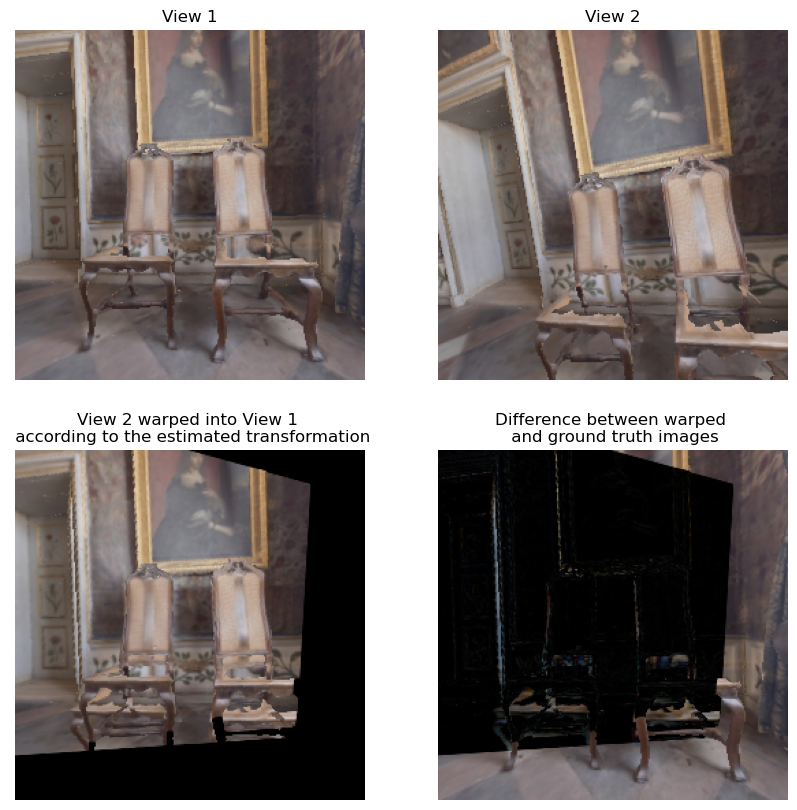

In [15]:
# Create sampler
sampler = torch.Tensor(xys_newimg).view(2, W, W).permute(1,2,0).unsqueeze(0)

# Create generated image
img1_tensor = ToTensor()(rgbs[0]).unsqueeze(0)
img2_tensor = ToTensor()(rgbs[1]).unsqueeze(0)
img2_warped = F.grid_sample(img2_tensor, sampler)

# Visualise
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax1.imshow(img1_tensor.squeeze().permute(1,2,0))
ax1.set_title("View 1", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(222)
ax1.imshow(img2_tensor.squeeze().permute(1,2,0))
ax1.set_title("View 2", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(223)
plt.imshow(img2_warped.squeeze().permute(1,2,0))
ax1.set_title("View 2 warped into View 1 \n according to the estimated transformation", fontsize='large')
ax1.axis('off')
ax1 = plt.subplot(224)
ax1.imshow(np.abs(img2_warped.squeeze().permute(1,2,0) - img1_tensor.squeeze().permute(1,2,0)))
ax1.set_title("Difference between warped \n and ground truth images", fontsize='large')
ax1.axis('off')
plt.show()